# Wavefunction Solution and Removal of Blazefunction 
## APF Data
### Melissa Carlson Fall 2018

In [34]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import scipy.interpolate as sciinterp
import scipy.constants
import scipy.signal

## Data Exploration

To open up the FITS files and extract the array of data for both the flux and wavelenth solutions we can use the function below. This allows for the shortcut openFile to be used rather than typing out a longer procedure. This works for most of the APF data files though it is possible with some files that the opened file will need to be indexed at one for the proper data to be extracted, something to look for when exploring your data files. 

In [7]:
def openFile(filename):
    
    """Given the filename of a fits file extracts the data.
       Works on both flux and wavlength solution files."""
    
    file = pf.open(filename)
    
    return file[0].data

Let's open up a file to see what it looks like. Below are two flux files for the same star taken on two different occasions and the corresponding wavelength solution. 

In [8]:
flux1 = openFile("rarp.210.fits")
flux2 = openFile("rbdl.232.fits")
wavelength = openFile("apf_wave_mod.fits")

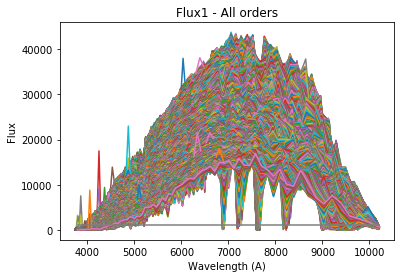

In [11]:
plt.plot(figsize = (11, 6))
plt.plot(wavelength, flux1)
plt.title("Flux1 - All orders")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

As you can see, plotting the flux in this way turns into a mess. Each line on the plot above represents one order of the data. Each order gives the flux for a certain section of the full wavelength solution. Within these orders there is a lot of overlap, so the same section of wavelength space may be covered more than once. To best visualize this data, we will view it one order at a time. We can do this by indexing the data as below.

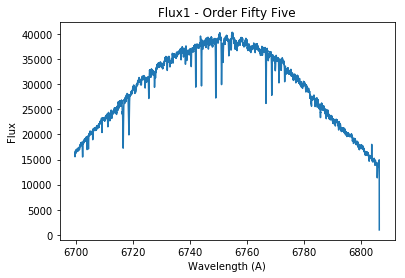

In [14]:
plt.plot(figsize = (11, 6))
plt.plot(wavelength[55], flux1[55])
plt.title("Flux1 - Order Fifty Five")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

## Wavelength Solution

Now that we know what the flux looks like overall and in one order, let's look at the wavelength solution for the order.

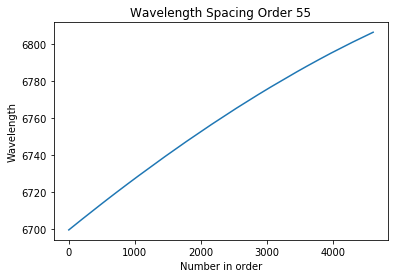

In [18]:
y = wavelength[55]
x = np.arange(0, len(y))
plt.title("Wavelength Spacing Order 55")
plt.ylabel("Wavelength")
plt.xlabel("Number in order")
plt.plot(x,y)
plt.show()

The curve to the above plot shows that the spacing between wavelength values is not constant throughout the order. Below is a function that takes in an order of the wavelength solution and a sampling rate. It then creates a new wavelength solution for the order with the same starting and ending wavelengths, and a number of bins equal to the starting number times the sampling rate. 

In [21]:
def newBins(order_wave_values, sample_rate = 1):
    
    """Calculates equally spaced wavlength bins that span the
       same total wavelength as the given bins."""
    
    new_bins = np.linspace(min(order_wave_values), max(order_wave_values), len(order_wave_values)*sample_rate)
    
    return new_bins

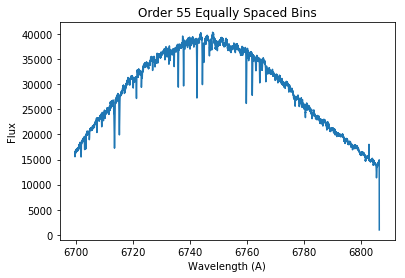

In [26]:
plt.plot(newBins(wavelength[55]), flux1[55])
plt.title("Order 55 Equally Spaced Bins")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

To easily compare our spectra with those in a database, it is helpful to put the data on a wavelength solution constant in change in wavelength over wavelength, according to the Doppler Formula. 

In [27]:
def deltalambda(wavelengths, velocity):

    """Create new wavlength bins constant in deltalambda/lambda."""
    
    c = scipy.constants.c
    new_wavelengths = np.array([])
    new_wavelengths = np.append(new_wavelengths, wavelengths[0])
    for i in range(len(wavelengths) - 1):
        y1 = wavelengths[i]
        delta = velocity*y1/c
        y2 = y1 + delta
        new_wavelengths = np.append(new_wavelengths, y2)
        y1 = y2
        
    return new_wavelengths

The above function goes through a wavlength order, calculates the change in wavelength needed according to the Doppler shift formula and builds a new wavelength solution for the order. A suggested value for v = 1300 m/s as this gives a similar delta wavelength value in the new solution as in the original wavelength solution for a value near the middle of the full wavelength solution.

Now that we have found several different wavelength solutions, we need some way of interpreting our data in terms of the new wavelength values. We can do this by interpolating or splining the flux data onto the new wavelength solution with the following function. 

In [28]:
def interpolate(new_bins, old_bins, old_flux, method = "cubic"):
    
    """Use the Scipy Interpolation function to put the flux data from
       the original wavelength solution (old_bins) to the new wavelength
       solution (new_bins). Returns a flux truncated by one pixel if the
       bounds of the new wavelength solution are larger than the old. Method
       specifies the kind of iterpolation to do. Options are in the docs for 
       scipy.interp1d. """
    
    if len(new_bins) > len(old_bins):
        new_bins = new_bins[0:-2]
    interpfunc = sciinterp.interp1d(old_bins, old_flux, kind = method, bounds_error=False)
    new_flux = interpfunc(new_bins)
    
    return new_flux[0:-2]

### Work to be done
The wavelength solution function currently works for one order. Because there are overlapping values between orders this does not work for the full wavelength solution at once. 

## Blaze Function Removal

The Blaze Function is a curve introduced to the data by the echelle grating in the detector. This is specific to each grating and thus detector. In the process of standardizing the data to compare with other spectra, we must remove the Blaze Function. I tried several methods of doing so described below, with a lamp removal being the most successful. 

## Method 1 - Polyfit the Spectra

In the above sections, within the star spectra you could see the curve to the data that is created by the Blaze function. One method to try and remove this is to fit a polynomial to the data to model the Blaze Function, and divide it out of the data. 

The curve should not be fit to the raw data. We want to fit a curve to the continum of the spectra, rather than the spectral features or cosmic rays. To avoid both of these interfering with the fit, the below function is used. The data is split into sections. Within each section find the 5th percentile brightness value. Remove all values dimmer than this, and take the median of the remaining values. This removes the dimmest pixels that represent absorption lines, and the median helps deal with absorption lines and potential cosmic rays. The resulting median value for the section is then paired with the center wavlength value of the section. The flux and wavlength values for each section are returned. 

In [49]:
def sectionAndAverage(wavelengths, flux, sections):
    
    """Split the wavelength and flux into bins of approximately 
       the same size according to sections value. Remove the values
       at or below the 5th percentile of brightness. Take the average
       of the remaining brightness values. Choose a wavelength 
       value that corresponds to the center of the bin."""
    
    #Find average flux of each bin after removing
    #Lowest flux values (bottom 5th percentile)
    flux_blocks = np.array_split(flux, sections)
    medians = np.array([])
    for section in flux_blocks:
        percentile5 = np.percentile(section, 5)
        morethan5th = section[section > percentile5]
        sectionmed = np.median(morethan5th)
        medians = np.append(medians, sectionmed)
    
    #Find wavelength value for bins
    wavesections = np.array_split(wavelengths, sections)
    points = np.array([])
    for section in wavesections:
        section_point = section[int(len(section)/2)]
        points = np.append(points, section_point)
        
    return points, medians

The function below takes in the flux and wavelength solution for an order, the number of sections to split it in, and the polynomial degree you wish to model the Blaze Function as. I have found that a 4th or 5th degree polynomial often works, though it depends on the particular order. This function plots the fit through the points found through the secion and median process, and the fit with the residuals. For now, text must be changed within the function for each order. 

In [52]:
def removeBlaze(wavelength, flux, sections, polydegree):
    
    """This version of blaze function removal does not normalize the
       flux or center the wavelengths before determining the polynomial
       coefficients, but normalizes with the division of the blaze function."""
    
    #Split spectra and wavelength solution into bins, average the 
    #appropriate flux values based on percentile, take mid-bin 
    #wavelength value to correspond to the bin's average
    points, medians = sectionAndAverage(wavelength, flux, sections)
    
    #Calculate the polynomial coefficients based on the above values
    coef = np.polyfit(points, medians, polydegree)
    curve_fit = np.poly1d(coef)
    
    #Calculate RMS between the spectra and the fit, large RMS
    #Value given non-normalized spectra
    #rmsNB = rms2Spectra(flux, curve_fit(wavelength))
    
    #Plot the fit with the median point values used 
    fig, ax = plt.subplots(1, 1, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax.scatter(wavelength, curve_fit(wavelength))
    ax.scatter(points, medians)
    ax.title.set_text("Polyfit Through Points Used")
    ax.set_ylabel("Flux")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Plot the fit with the residuals
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax1 = axs[0]
    ax1.plot(wavelength, flux)
    ax1.plot(wavelength, curve_fit(wavelength), "ro")
    ax1.title.set_text("Polynomial Fit Order 25")
    ax1.set_ylabel("Normalized Flux")
    ax2 = axs[1]
    ax2.plot(wavelength, flux - curve_fit(wavelength))
    ax2.set_ylabel("Residuals")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Return the flux with the blaze function divided out
    return flux/curve_fit(wavelength)

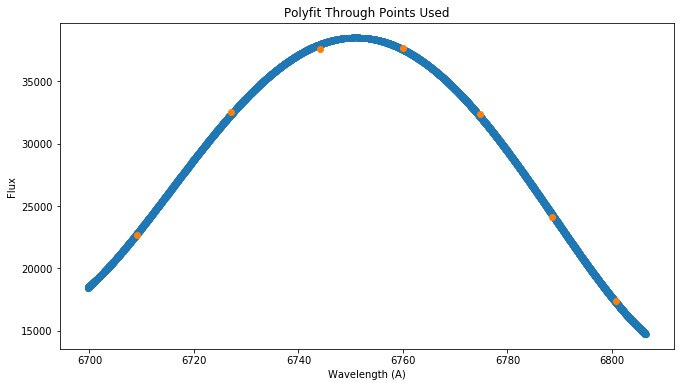

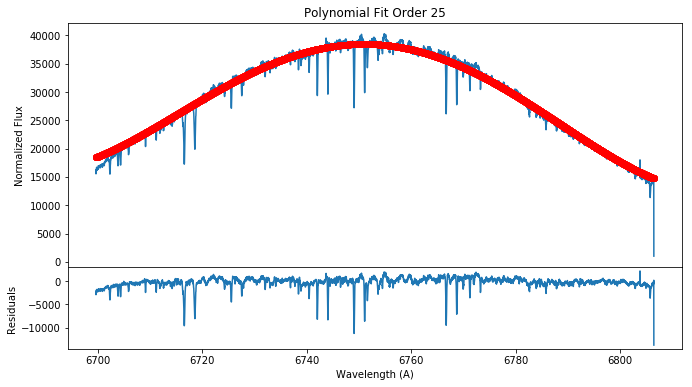

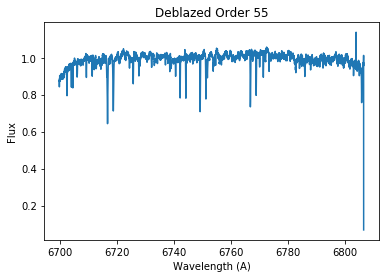

In [56]:
plt.plot(wavelength[55], removeBlaze(wavelength[55], flux1[55], 7, 4))
plt.title("Deblazed Order 55")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

## Method 2 - B Star

One way we may be able to remove the blaze function is to not look at a star with many absorption features, but one with very few. A B-Star has very few spectral features and acts as a "lamp in the sky". The light from this star with go through all optics within the telescope. When the features it does have are smoothed, the result should be the shape the Blaze Function has changed the data to. If we divide this out from other spectra, it should divide out the Blaze Function. 

Open up a file containing the spectra of a B-Star.

In [30]:
bstar = openFile("rbha.187.fits")
bstar55 = bstar[55]

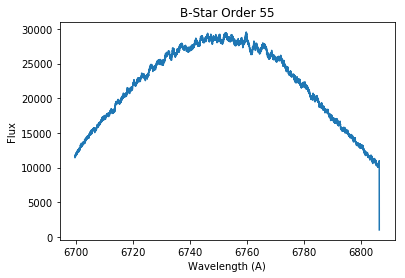

In [32]:
plt.plot(wavelength[55], bstar[55])
plt.title("B-Star Order 55")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

The flux for this order can be smoothed with a Savitzky-Golay filter, the window size and polynomial degree are specified in the function.

In [35]:
smoothstar = scipy.signal.savgol_filter(bstar[55], 431, 2)

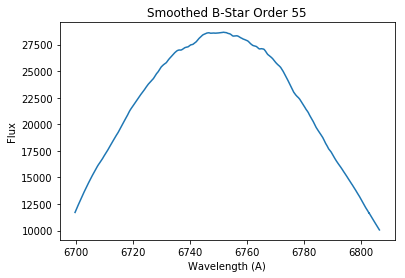

In [37]:
plt.plot(wavelength[55], smoothstar)
plt.title("Smoothed B-Star Order 55")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

This looks pretty good, though there are still some irregularites toward the center of the order. Let's explore other orders to look for consistency. 

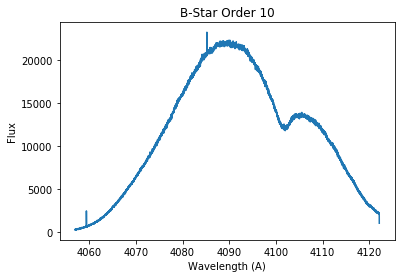

In [45]:
bstar10 = bstar[10]
plt.plot(wavelength[10], bstar10)
plt.title('B-Star Order 10')
plt.ylabel('Flux')
plt.xlabel('Wavelength (A)')
plt.show()

From inspection, this order will not work well for modeling the Blaze Function. By looking through each order of the B-Star spectra it seems that many orders will not work well, and it would be better to explore other methods of removal. 

## Method 3 - Lamp Fit

This method works very similarly to the B-Star method, but looks at a lamp rather than a star. This light does not go through all the optics of the telescope but does a pretty good job of showing the Blaze Function effects. In the same way as before, we will smooth the data and divide it out of another spectra. 

In [59]:
lamp = openFile("rbel.139.fits")

The lamp shows some irregularites but these are mostly removed with smoothing. 

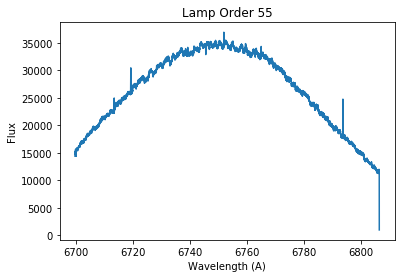

In [62]:
plt.plot(wavelength[55], lamp[55])
plt.title("Lamp Order 55")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

In [60]:
smoothlamp = scipy.signal.savgol_filter(lamp[55], 431, 2)

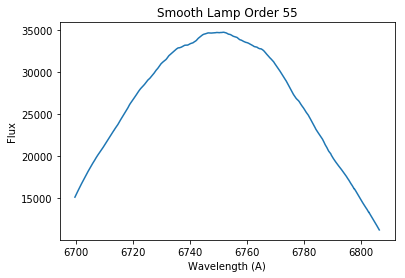

In [63]:
plt.plot(wavelength[55], smoothlamp)
plt.title("Smooth Lamp Order 55")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

Using the order now to remove the Blaze Function from another spectra we get the below results. Unlike using a polynomial to fit the spectra itself, using the lamp does not properly normalize the results because the flux range is different between the lamp and the other spectra. 

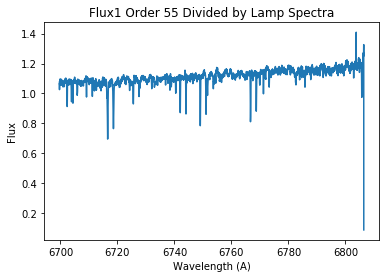

In [66]:
plt.plot(wavelength[55], flux1[55]/smoothlamp)
plt.title("Flux1 Order 55 Divided by Lamp Spectra")
plt.ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

## Additional Functions

The below function finds the RMS value between two spectra. This acts as a gauge of how similar two distributions are and has helped with determining how effective the above methods were, and assists in the shifting method below. 

In [67]:
def rms2Spectra(spec1, spec2):
    assert len(spec1) == len(spec2)

    """Determines the RMS value between two spectra 
       using N-1 normalization. """
    
    diff = np.array([])
    for fluxval in range(len(spec1)):
        diff = np.append(diff, spec1[fluxval] - spec2[fluxval])
    diffsquares = diff**2
    sumsquares = np.sum(diffsquares)
    normed = sumsquares/(len(spec1) - 1)
    return normed**(0.5)

In [ ]:
def shiftSpectra(wavelength, flux1NB, flux2NB, maxshift):
    
    allRMS = np.array([])
    shiftVals = np.array([])
    for i in range(-maxshift, maxshift + 1):
        #make a copy of the flux so rolling does
        #not affect original data
        copyflux1 = np.copy(flux1NB)
        copyflux2 = np.copy(flux2NB)
        #shift flux by i
        copyflux2 = np.roll(copyflux2, i)
        #truncate flux arrays
        copyflux1 = copyflux1[abs(i):len(copyflux1) - abs(i)]
        copyflux2 = copyflux2[abs(i):len(copyflux2) - abs(i)]
        #calculate new rms
        shiftRMS = rms2Spectra(copyflux1, copyflux2)
        #store RMS value
        allRMS = np.append(allRMS, shiftRMS)
        #store shift value for the rms
        shiftVals = np.append(shiftVals, i)
    index = np.argmin(allRMS)
    shift = int(shiftVals[index])
    print(shift)
    truncwave = wavelength[abs(shift): len(wavelength) - abs(shift)]
    truncflux1 = flux1NB[abs(shift): len(flux1NB) - abs(shift)]
    truncflux2 = np.roll(flux2NB, - abs(shift))[abs(shift): len(flux2NB) - abs(shift)]
    
    return truncwave, truncflux1, truncflux2